# Tutorial on deep learning for medical image segmentation for SSIMA 2018

Benjamin Irving, 2018



# This tutorial covers
- Keras (with tensorflow) for deep learning
- Optimisation functions
- U-Net convolutional neural network
- Model training
- Data augmentation
- Prediction
- Understanding the trained layers

# Aim
- Everyone will have different levels of experience. 
- I'm using tools such as Github, git, python environments, jupyter notebooks, keras. 
- If you familiar with them then great but if not then don't worry about it. You can learn the bits that are useful to you later. 
- The real aim of this tutorial is to show how quick it can be to build a deep convolutional network for segmentation


# Running this tutorial yourself

- View these slides as html: https://github.com/benjaminirving/SSIMA-2018-tutorial-deep-learning-med-segmentation
- Sent these earlier but can be run at any time. 


- Or run them in a python Jupyter notebook
- [Setup instructions are available here](https://github.com/benjaminirving/SSIMA-2018-tutorial-deep-learning-med-segmentation/blob/master/Tutorial%201%20-%20Setup.ipynb) 
- In your python environment this can be activated with the command: `jupyter notebook`

![jupyter](img/Selection_021.jpg)
![jupyter](http://jupyter.org/assets/main-logo.svg)


# Data and trained model

- Added the model yesterday

Folders:
- `data/DRIVE`
- `model/`


# Code

- Originally based on: https://github.com/jocicmarko/ultrasound-nerve-segmentation
- Heavily modified for retina segmentation

# Problem: Segmentation of the retinal vessels 
- I generally work with MRI and CT but these images are much more light weight and therefore easier to demo
- Similar deep learning framework can be used for both which shows the flexibility of these frameworks



![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Schematic_diagram_of_the_human_eye_en.svg/416px-Schematic_diagram_of_the_human_eye_en.svg.png)

From wikipedia: https://en.wikipedia.org/wiki/Fovea_centralis

![](img/Selection_019.jpg)

# Importing the libraries



![keras](img/keras.png)

https://keras.io/


In [1]:
%matplotlib inline

import os
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

import matplotlib.pyplot as plt



Using TensorFlow backend.


In [2]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_cols = 512
img_rows = 512

smooth = 1.

model_dir = 'models/'

# Loss function

e.g. mean_squared_error

# Dice coefficient

$$DSC = \frac{2|X|\cap|Y|}{|X| + |Y|}$$

Smoothing function to avoid inf

In [3]:
def dice_coef(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


# Deep network

# U-Net convolutional network

<img src="img/unet.png" alt="unet"  width="75%">

From Irving et al (2017)

1. [Olaf Ronneberger, Philipp Fischer, Thomas Brox (2015) U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

2. [Irving et al (2017) Deep quantitative liver segmentation and vessel
exclusion to assist in liver assessment](http://www.birving.com/papers/Irving-Deep_Quantitative_Liver_Segmentation_and_Vessel_Exclusion_to_Assist_in_Liver_Assessment_2017.pdf)


In [4]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2),)(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv7')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv9')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    # TODO: temporary switch from 5e-5 to 1e-5
    model.compile(optimizer=Adam(lr=5e-5), loss=dice_coef_loss, metrics=[dice_coef])
    
    print('model created')

    return model


# Training

## Training data

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
model created
------------------------------
Fitting model...
------------------------------


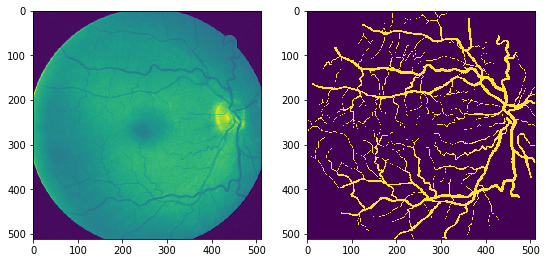

In [16]:

options = {}
options['augmentation'] = True

epochs = 2001
batch_size = 5

print('-'*30)
print('Loading and preprocessing train data...')
print('-'*30)

train_data = np.load('data/DRIVE/imgs_train.npz')
imgs_train, imgs_mask_train = train_data['imgs'], train_data['imgs_mask']

img_test = imgs_train[-1]
img_mask_test = imgs_mask_train[-1]
img_test = np.expand_dims(img_test, axis=0)
img_mask_test = np.expand_dims(img_mask_test, axis=0)
imgs_train = np.delete(imgs_train, -1, 0)
imgs_mask_train = np.delete(imgs_mask_train, -1, 0)

imgs_train = imgs_train.astype('float32')
imgs_train = imgs_train / imgs_train.max()

# mean = np.mean(imgs_train)  # mean for data centering
# std = np.std(imgs_train)  # std for data normalization
#
# imgs_train -= mean
# imgs_train /= std

imgs_mask_train = imgs_mask_train.astype('float32')
imgs_mask_train = imgs_mask_train > 0.5

print('-'*30)
print('Creating and compiling model...')
print('-'*30)
model = get_unet()

print('-'*30)
print('Fitting model...')
print('-'*30)

plt.figure(figsize=(9,9))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(imgs_train[2]))
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(imgs_mask_train[2]))
plt.show()
        

# Data augmentation

- Excerpts from the training function above

In [22]:


# Data augmentation
# Image generation from:
# https://keras.io/preprocessing/image/

# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=10.,
                     width_shift_range=0.01,
                     height_shift_range=0.01,
                     zoom_range=0.1,
                     fill_mode='constant',
                     cval=0)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(imgs_train, augment=True, seed=seed)
mask_datagen.fit(imgs_mask_train, augment=True, seed=seed)

image_generator = image_datagen.flow(imgs_train, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(imgs_mask_train, batch_size=batch_size, seed=seed)

gen1 = zip(image_generator, mask_generator)


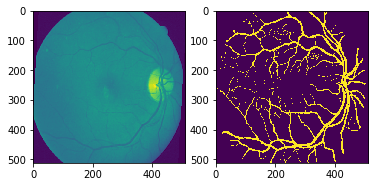

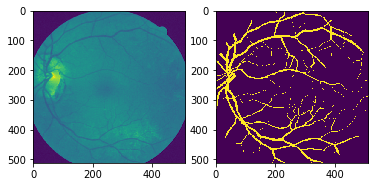

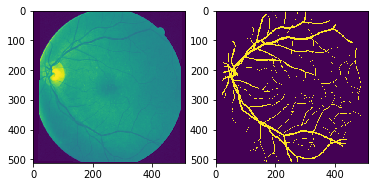

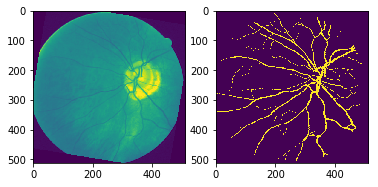

In [23]:
batches = 0
for x_batch, y_batch in gen1:
    y_batch = y_batch > 0.5
#     model.fit(x_batch, y_batch, verbose=0, epochs=1)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(x_batch[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(y_batch[0]))
    
    batches += 1
    if batches >= len(imgs_train) / batch_size:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break
        
plt.show()


# Why do we need augmentation?
- 

# Training
- Slow process
- Definitely requires a decent GPU

In [ ]:

# here's a more "manual" example
for e in range(epochs):

    batches = 0
    for x_batch, y_batch in gen1:
        y_batch = y_batch > 0.5
        model.fit(x_batch, y_batch, verbose=0, epochs=1)

        # plt.figure()
        # plt.imshow(np.squeeze(x_batch[0]))
        # plt.figure()
        # plt.imshow(np.squeeze(y_batch[0]))
        # plt.show()

        batches += 1
        if batches >= len(imgs_train) / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

    if e % 400 == 0:

        print('Epoch', e)

        # Show a single case

        print('Epoch {}'.format(e))

        pred1 = model.predict(img_test)

        plt.figure()
        plt.subplot(1, 3, 1)
        plt.title('Example')
        plt.imshow(np.squeeze(img_test))
        plt.subplot(1, 3, 2)
        plt.title('Model Epoch {}'.format(e))
        plt.imshow(np.squeeze(pred1))
        plt.subplot(1, 3, 3)
        plt.title('Ground truth')
        plt.imshow(np.squeeze(img_mask_test))
        plt.show()

        model.save_weights(model_dir + "modelaug{}.h5".format(e))


# Model outputs at different epochs during training

![img/training0.png](img/training0.png)
![img/training400.png](img/training400.png)


# Model outputs at different epochs during training

![img/training800.png](img/training800.png)
![img/training1200.png](img/training1200.png)

# Predicting the output on unseen test cases



In [26]:
def dice_coeff_standard(yt, yp):

    yt = yt > 0.5
    yp = yp > 0.5

    return 2*np.sum(np.logical_and(yt, yp)) / (np.sum(yt) + np.sum(yp))


def predict():

    model = get_unet()

    print('- ' * 30)
    print('Loading and preprocessing test data...')
    print('- ' * 30)

    test_data = np.load('data/DRIVE/imgs_test.npz')
    imgs_test, imgs_mask_test = test_data['imgs'], test_data['imgs_mask']

    imgs_test = imgs_test.astype('float32')
    imgs_test = imgs_test / imgs_test.max()
    # imgs_test -= mean
    # imgs_test /= std

    print('- ' * 30)
    print('Loading saved weights...')
    print('- ' * 30)
    model.load_weights('models/modelaug3900.h5')

    print('- ' * 30)
    print('Predicting masks on test data...')
    print('- ' * 30)

    imgs_mask_pred = model.predict(imgs_test[:5], verbose=1)

#     np.save('imgs_mask_test.npy', imgs_mask_test)

    dice_all = []

    for impred, im, imtest in zip(imgs_mask_pred[:5], imgs_test[:5], imgs_mask_test[:5]):

        dice_all.append(dice_coeff_standard(imtest, impred))

        plt.figure(figsize=(9,9))
        plt.title("Ground truth and prediction for test set. Dice {}".format(dice_all[-1]))

        plt.subplot(1, 3, 1)
        plt.imshow(np.squeeze(im))
        plt.subplot(1, 3, 2)
        plt.imshow(np.squeeze(imtest))
        plt.subplot(1, 3, 3)
        plt.imshow(np.squeeze(impred))

    plt.show()

    print("Mean dice: ", np.mean(dice_all))


model created
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Loading and preprocessing test data...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Loading saved weights...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Predicting masks on test data...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
5/5 [==============================] - 0s 60ms/step


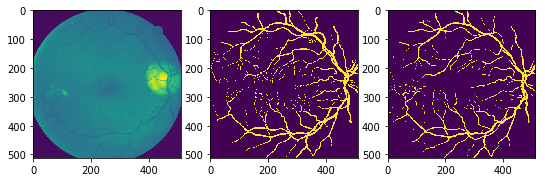

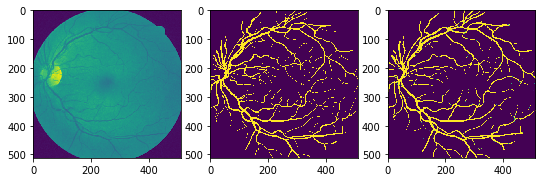

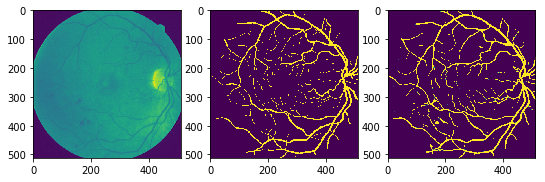

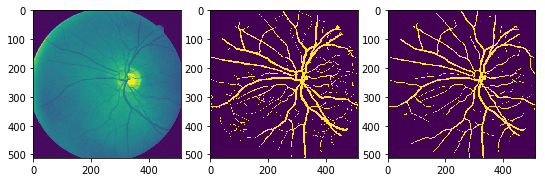

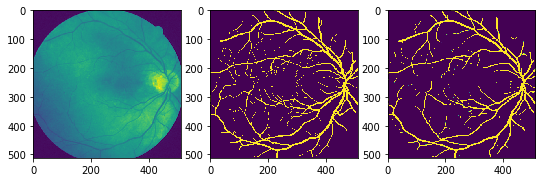

Mean dice:  0.7858877641007169


In [27]:
predict()

# What do the layers see?

In [22]:
# Importing montage function
from skimage.util import montage

def generate_layer_outputs():
    # Reloading the test data
    test_data = np.load('data/DRIVE/imgs_test.npz')
    imgs_test, imgs_mask_test = test_data['imgs'], test_data['imgs_mask']
    imgs_test = imgs_test.astype('float32')
    imgs_test = imgs_test / imgs_test.max()

    # Extracting 1 example
    example_image = imgs_test[0]
    example_image = np.expand_dims(example_image, axis=0)

    layer_vis = ['conv1', 'conv3', 'conv5', 'conv7', 'conv9']

    model = get_unet()
    print('- ' * 30)
    print('Loading saved weights...')
    print('- ' * 30)
    model.load_weights('models/modelaug3900.h5')

    for l1name in layer_vis:

        l1_model = model.get_layer(l1name)
        l1_function = K.function([model.layers[0].input, K.learning_phase()], [l1_model.output])
        l1_output = l1_function([example_image, 0])[0]

        print("Layer shape: ", l1_output.shape)

        l1_output = np.squeeze(l1_output)
        l1_output = np.rollaxis(l1_output, 2, 0)

        print("Layer shape (montage): ", l1_output.shape)

        plt.figure(figsize=(9,9))
        plt.title('Output of 9 filters from layer: ' + l1name)
        m1 = montage(l1_output[:9])
        plt.imshow(m1)

    #     img_width = layer_output.shape[1]
    #     img_height = layer_output.shape[2]
    #     n = int(np.floor(np.sqrt(l1_output.shape[-1])))

    
    
    

model created
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Loading saved weights...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Layer shape:  (1, 512, 512, 32)
Layer shape (montage):  (32, 512, 512)
Layer shape:  (1, 128, 128, 128)
Layer shape (montage):  (128, 128, 128)
Layer shape:  (1, 32, 32, 512)
Layer shape (montage):  (512, 32, 32)
Layer shape:  (1, 128, 128, 128)
Layer shape (montage):  (128, 128, 128)
Layer shape:  (1, 512, 512, 32)
Layer shape (montage):  (32, 512, 512)


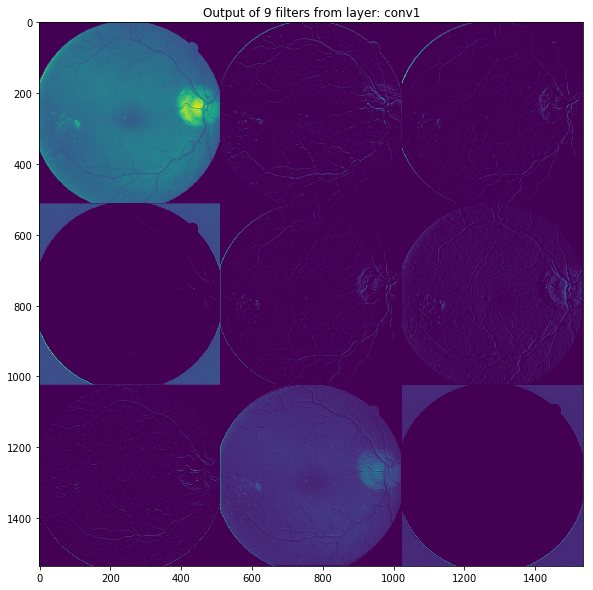

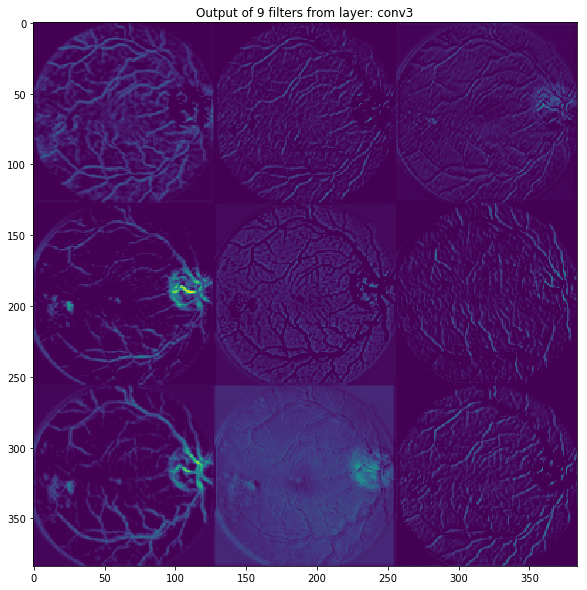

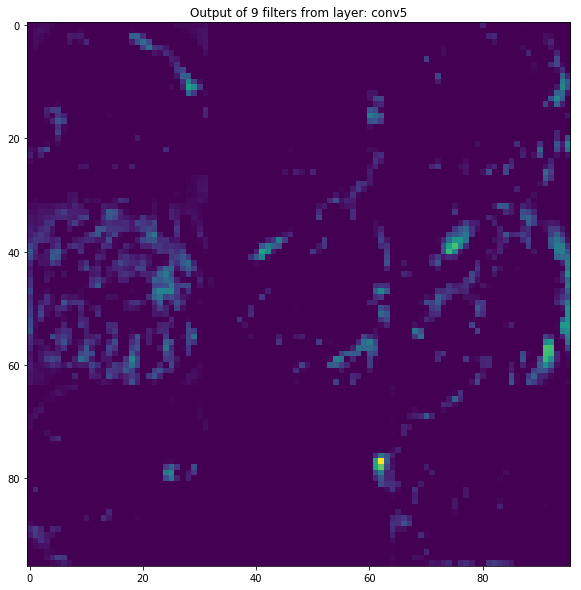

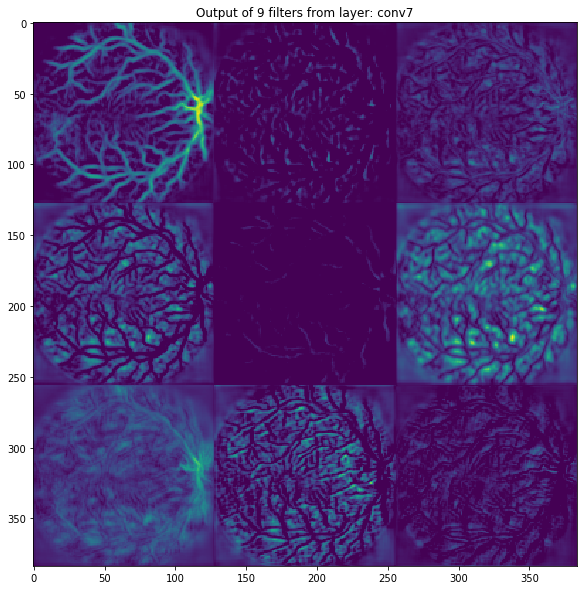

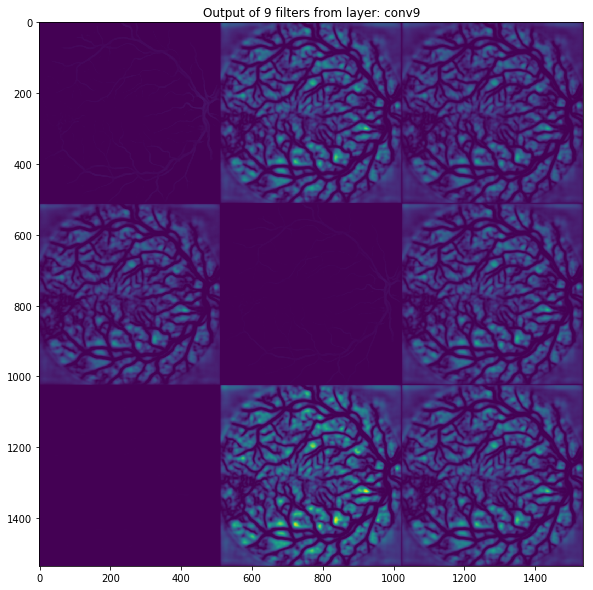

In [23]:
generate_layer_outputs()

In [11]:
print('merci')

merci
